In [94]:
# Complex Semantic Segmentation (U-Net Style)
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from complexPyTorch.complexLayers import ComplexConv2d, ComplexConvTranspose2d, ComplexBatchNorm2d, ComplexAvgPool2d
from complexPyTorch.complexFunctions import complex_relu, complex_dropout


In [95]:
# -----------------------
# CamVid Dataset Loader
# -----------------------
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform

        self.image_names = sorted([
            name for name in os.listdir(image_dir)
            if os.path.exists(os.path.join(label_dir, name.replace(".png", "_L.png")))
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_name = img_name.replace(".png", "_L.png")
        label_path = os.path.join(self.label_dir, label_name)

        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [96]:
# class index → RGB color mapping
CAMVID_COLORMAP = {
    (128, 128, 128): 0,  # Sky
    (128, 0, 0): 1,      # Building
    (192, 192, 128): 2,  # Pole
    (128, 64, 128): 3,   # Road
    (0, 0, 192): 4,      # Pavement
    (128, 128, 0): 5,    # Tree
    (192, 128, 128): 6,  # SignSymbol
    (64, 64, 128): 7,    # Fence
    (64, 0, 128): 8,     # Car
    (64, 64, 0): 9,      # Pedestrian
    (0, 128, 192): 10,   # Bicyclist
    (0, 0, 0): 11        # Void
}

def rgb_to_class(label_img):
    label = np.array(label_img)
    h, w, _ = label.shape
    mask = np.zeros((h, w), dtype=np.int64)

    for rgb, idx in CAMVID_COLORMAP.items():
        mask[(label == rgb).all(axis=2)] = idx

    return torch.from_numpy(mask)

In [97]:
# -----------------------
# Transforms
# -----------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    lambda x: x.to(torch.complex64)
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    lambda img: rgb_to_class(img)
])

In [98]:
# -----------------------
# Dataset and Loader
# -----------------------
camvid_root = "./data/camvid"
train_dataset = CamVidDataset(
    image_dir=os.path.join(camvid_root, "images"),
    label_dir=os.path.join(camvid_root, "labels"),
    transform=transform,
    target_transform=target_transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


In [99]:
train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape

(torch.Size([3, 128, 128]), torch.Size([128, 128]))

In [115]:
# def complex_avg_pool2d(x, kernel_size, stride=None, padding=0):
#     return torch.complex(
#         F.avg_pool2d(x.real, kernel_size, stride, padding),
#         F.avg_pool2d(x.imag, kernel_size, stride, padding)
#     )

# class ComplexUNet(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.enc1 = ComplexConv2d(3, 16, 3, padding=1)
#         self.enc2 = ComplexConv2d(16, 32, 3, padding=1)
#         self.enc3 = ComplexConv2d(32, 64, 3, padding=1)

#         self.dec2 = ComplexConvTranspose2d(64, 32, 2, stride=2)
#         self.dec1 = ComplexConvTranspose2d(32, 16, 2, stride=2)

#         self.final = ComplexConv2d(16, num_classes, 1)

#     def forward(self, x):
#         x1 = complex_relu(self.enc1(x))
#         x2 = complex_relu(self.enc2(complex_avg_pool2d(x1, 2)))
#         x3 = complex_relu(self.enc3(complex_avg_pool2d(x2, 2)))

#         y2 = complex_relu(self.dec2(x3))
#         y1 = complex_relu(self.dec1(y2))

#         out = self.final(y1)
#         return F.log_softmax(out.abs(), dim=1)

# -----------------------
# Complex AvgPool Helper
# -----------------------
def complex_avg_pool2d(x, kernel_size, stride=None, padding=0):
    return torch.complex(
        F.avg_pool2d(x.real, kernel_size, stride, padding),
        F.avg_pool2d(x.imag, kernel_size, stride, padding)
    )

class ComplexReLU(nn.Module):
    def forward(self, x):
        return complex_relu(x)
    
class ComplexDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, inp):
        if not self.training or self.p == 0.0:
            return inp
        mask = torch.ones_like(inp.real)
        mask = F.dropout(mask, self.p, self.training) * 1 / (1 - self.p)
        return torch.complex(inp.real * mask, inp.imag * mask)


# -----------------------
# Complex U-Net
# -----------------------
class ComplexUNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.ModuleList()
        self.pool = nn.ModuleList()
        
        # First encoder block (no pooling before this)
        self.encoder.append(
            nn.Sequential(
                ComplexConv2d(in_channels, features[0], 3, padding=1),
                ComplexBatchNorm2d(features[0]),
                ComplexReLU(),
                ComplexConv2d(features[0], features[0], 3, padding=1),
                ComplexBatchNorm2d(features[0]),
                ComplexReLU()
            )
        )
        
        # Rest of encoder blocks with pooling
        for i in range(1, len(features)):
            self.pool.append(ComplexAvgPool2d(kernel_size=2))
            self.encoder.append(
                nn.Sequential(
                    ComplexConv2d(features[i-1], features[i], 3, padding=1),
                    ComplexBatchNorm2d(features[i]),
                    ComplexReLU(),
                    ComplexConv2d(features[i], features[i], 3, padding=1),
                    ComplexBatchNorm2d(features[i]),
                    ComplexReLU()
                )
            )
        
        # Decoder (upsampling)
        self.decoder = nn.ModuleList()
        self.upconv = nn.ModuleList()
        
        # Create decoder blocks
        for i in range(len(features)-1, 0, -1):
            self.upconv.append(
                ComplexConvTranspose2d(features[i], features[i-1], 2, stride=2)
            )
            self.decoder.append(
                nn.Sequential(
                    ComplexConv2d(features[i], features[i-1], 3, padding=1),
                    ComplexBatchNorm2d(features[i-1]),
                    ComplexReLU(),
                    ComplexConv2d(features[i-1], features[i-1], 3, padding=1),
                    ComplexBatchNorm2d(features[i-1]),
                    ComplexReLU()
                )
            )
        
        # Final convolution
        self.final = ComplexConv2d(features[0], num_classes, 1)
        
        # Dropout for regularization
        self.dropout = ComplexDropout(0.3)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, ComplexConv2d):
            nn.init.kaiming_normal_(m.conv_r.weight, mode='fan_out', nonlinearity='relu')
            nn.init.kaiming_normal_(m.conv_i.weight, mode='fan_out', nonlinearity='relu')
            if m.conv_r.bias is not None:
                nn.init.constant_(m.conv_r.bias, 0)
                nn.init.constant_(m.conv_i.bias, 0)
        
        elif isinstance(m, ComplexConvTranspose2d):
            nn.init.kaiming_normal_(m.conv_tran_r.weight, mode='fan_out', nonlinearity='relu')
            nn.init.kaiming_normal_(m.conv_tran_i.weight, mode='fan_out', nonlinearity='relu')
            if m.conv_tran_r.bias is not None:
                nn.init.constant_(m.conv_tran_r.bias, 0)
                nn.init.constant_(m.conv_tran_i.bias, 0)


    
    def forward(self, x):
        # Store encoder outputs for skip connections
        skip_connections = []
        
        # Encoder path
        for i in range(len(self.encoder)):
            if i > 0:  # Apply pooling for all but first layer
                x = self.pool[i-1](x)
            x = self.encoder[i](x)
            if i < len(self.encoder)-1:  # Save all but bottleneck for skip connections
                skip_connections.append(x)
        
        # Apply dropout at bottleneck for regularization
        x = self.dropout(x)
        
        # Decoder path with skip connections
        for i in range(len(self.decoder)):
            x = self.upconv[i](x)
            # Get corresponding skip connection and concatenate
            skip = skip_connections.pop()
            
            # Handle potential size mismatches
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            
            # Concatenate along channel dimension (need to concatenate real and imaginary parts properly)
            x = torch.complex(
                torch.cat([x.real, skip.real], dim=1),
                torch.cat([x.imag, skip.imag], dim=1)
            )
            
            x = self.decoder[i](x)
        
        # Final prediction
        x = self.final(x)
        
        # Use absolute value for softmax - this handles the complex representation
        return F.log_softmax(x.abs(), dim=1)


In [116]:
# -----------------------
# Train and Evaluate
# -----------------------
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(f"Output shape: {output.shape}")  # Should be (N, C, H, W)
        # print(f"Target shape: {target.shape}")  # Should be (N, H, W)
        # return  # For debugging, remove this in production
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss / len(loader):.4f}")

In [117]:
# -----------------------
# Setup and Run
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexUNet(num_classes=21).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train(model, train_loader, optimizer, device)

Epoch 1
Train Loss: 1.3094
Epoch 2
Train Loss: 0.8540
Epoch 3
Train Loss: 0.7299
Epoch 4
Train Loss: 0.6468
Epoch 5
Train Loss: 0.6131


In [120]:
import matplotlib.pyplot as plt

def test(model, loader, device):
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(loader):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1).cpu()  # Shape: [batch_size, H, W]
            
            # Visualize the first image of the batch
            img = data[0].cpu()
            mask = pred[0]
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.title("Input Image")
            plt.imshow(img.abs().permute(1, 2, 0))  # Since it's complex
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.title("Predicted Segmentation")
            plt.imshow(mask, cmap='tab20')
            plt.axis("off")
            
            plt.show()

            # You can break early if just testing visualization
            break


Test Iteration 1


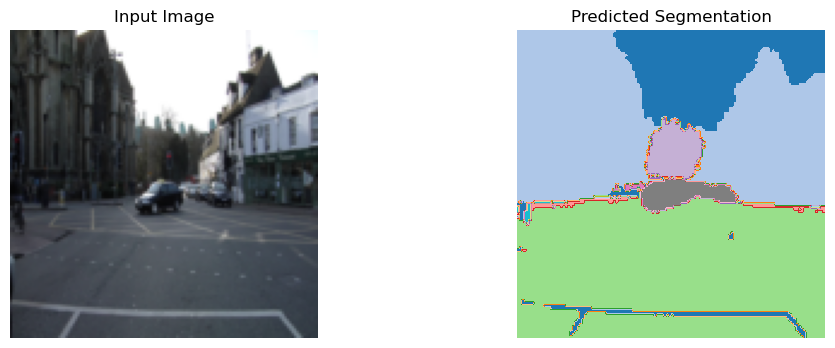

Test Iteration 2


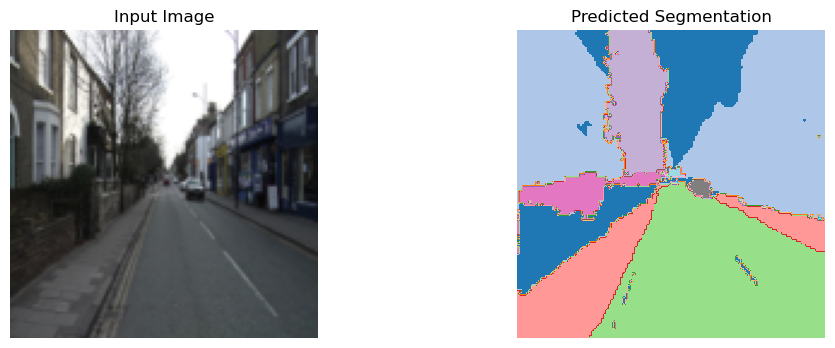

Test Iteration 3


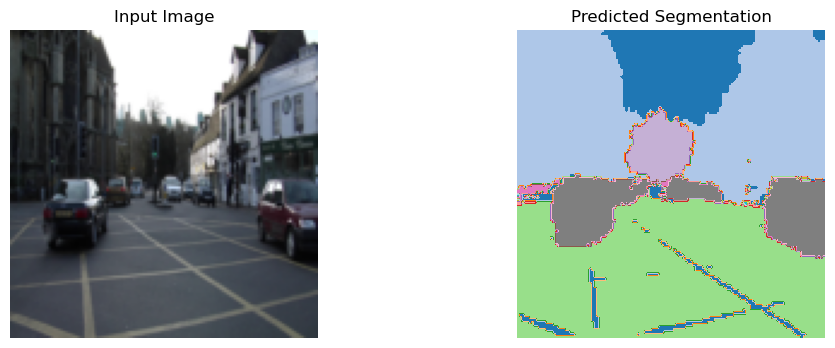

Test Iteration 4


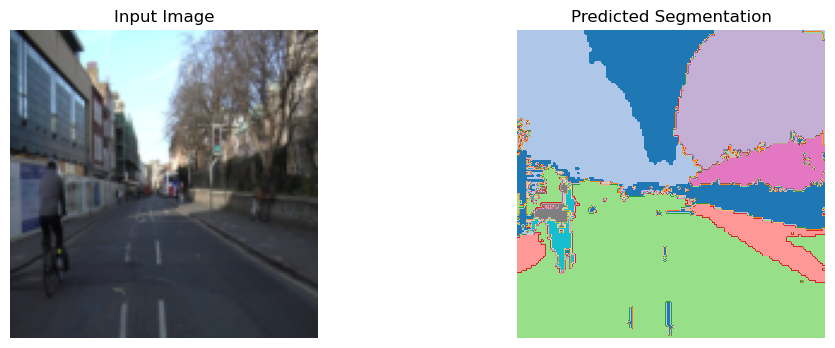

Test Iteration 5


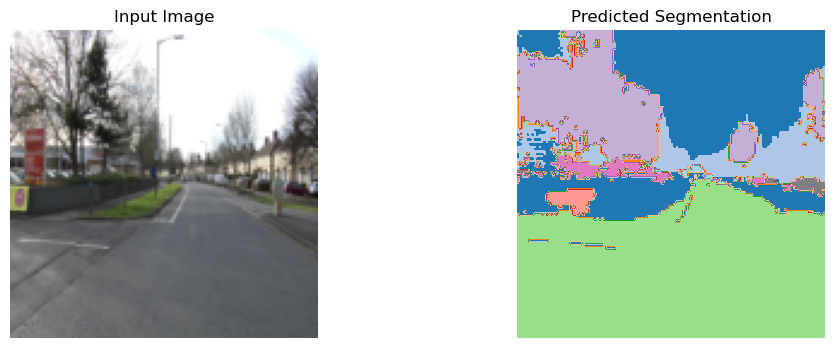

Test Iteration 6


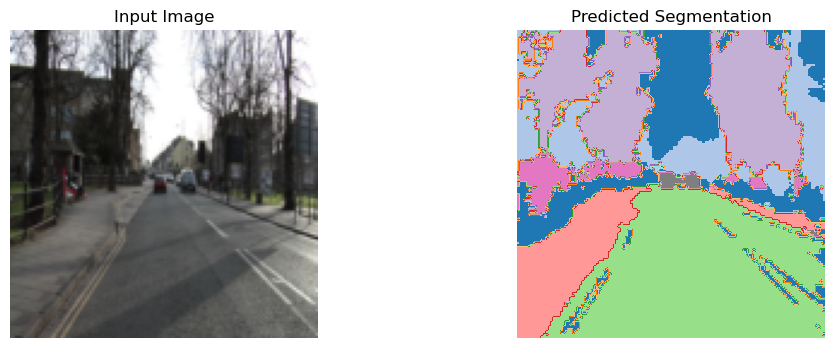

Test Iteration 7


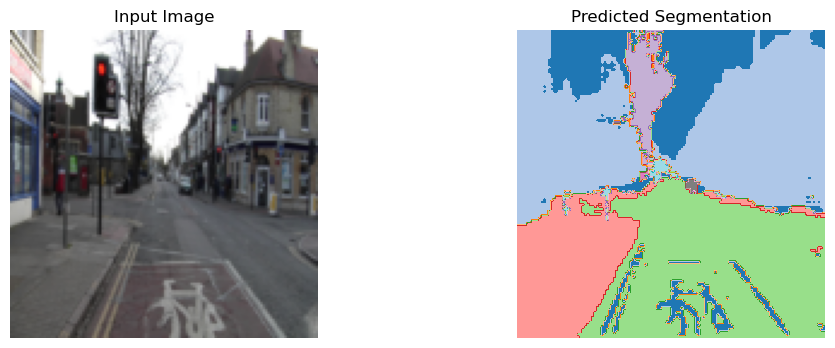

Test Iteration 8


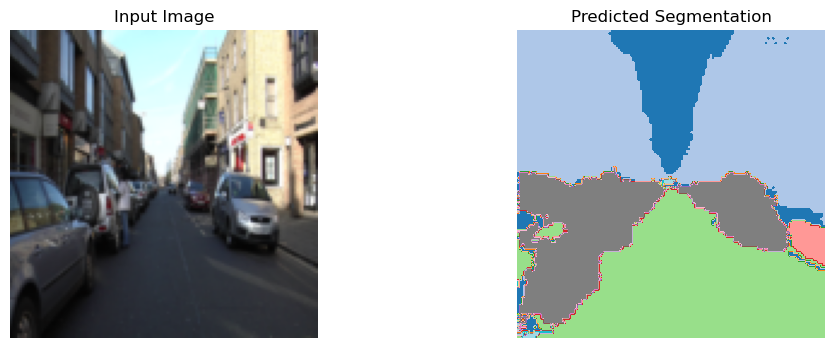

Test Iteration 9


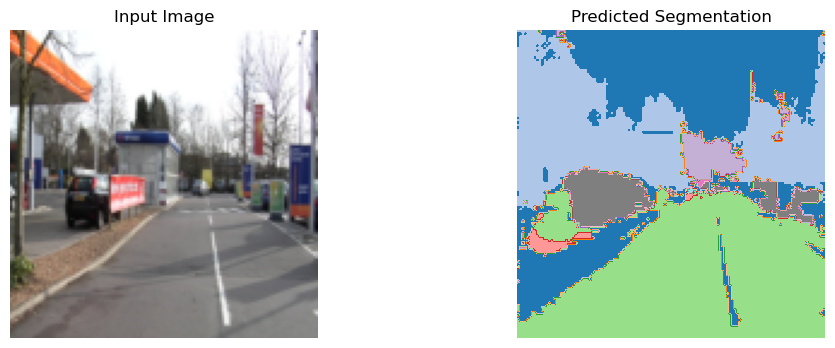

Test Iteration 10


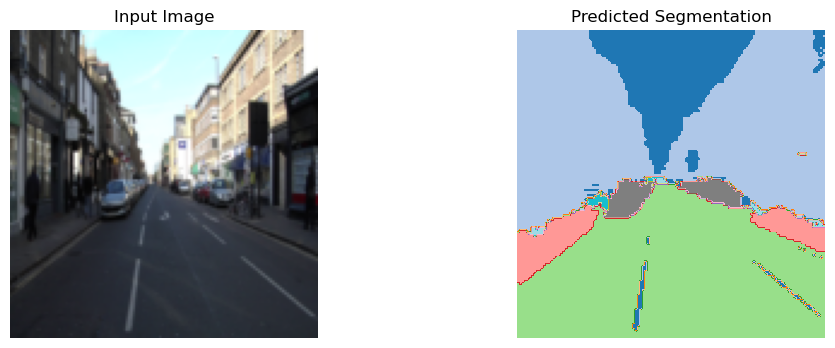

In [127]:
for i in range(10):
    print(f"Test Iteration {i+1}")
    test(model, train_loader, device)


In [126]:
# -----------------------
# Save Model
# -----------------------
torch.save(model.state_dict(), "complex_unet_pascalvoc.pth")
